In [33]:
import numpy as np
import scipy.linalg as linalg
import tensorly as tl
from matplotlib import pyplot as plt

%matplotlib inline 

Now let's try another variant of tSSA. Method's demonstration is held on electricity dataset

### Data extraction

In [34]:
# as in demo, first extract neccessary data

import pandas as pd

raw_data = pd.read_csv("./data/household_power_consumption.csv")
raw_data.rename(columns={'Sub_metering_1': 'kitchen_power', 'Sub_metering_2': 'loundry_power', 'Sub_metering_3': 'heater_conditioner_power'},
                inplace=True)
raw_data.head()

# convert strings to pandas dates
raw_data['Date'] = pd.to_datetime(raw_data['Date'], dayfirst=True)

# slice one year, say 2008
raw_data = raw_data[raw_data['Date'] >= pd.to_datetime('01/01/2008', dayfirst=True)]
raw_data = raw_data[raw_data['Date'] <= pd.to_datetime('30/12/2008', dayfirst=True)]

# drop unnessasary columns
raw_data = raw_data.drop(columns=['Time', 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity'])

# clean data
print(raw_data['kitchen_power'].__len__())
temp = (raw_data['kitchen_power'].str.find('?') != -1)
temp1 = raw_data['kitchen_power'][temp == True]
raw_data.drop(temp1.index, inplace=True)
# checking successful elimination
print(raw_data['kitchen_power'].__len__())

temp = (raw_data['loundry_power'].str.find('?') != -1)
temp1 = raw_data['loundry_power'][temp == True]
raw_data.drop(temp1.index, inplace=True)
print(raw_data['loundry_power'].__len__())

# change type of column to float
raw_data['kitchen_power'] = pd.to_numeric(raw_data['kitchen_power'])
raw_data['loundry_power'] = pd.to_numeric(raw_data['loundry_power'])
raw_data.dtypes

/tmp/ipykernel_765/1130943266.py:5: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv("./data/household_power_consumption.csv")


525600
525465
525465


Date                        datetime64[ns]
kitchen_power                      float64
loundry_power                      float64
heater_conditioner_power           float64
dtype: object

In [35]:
# now we're going to average measurement's daywise

# know how many days in a year
num_days = raw_data['Date'].unique().shape[0]
# container for averaged data
data = np.zeros((num_days, 3))

for i, day in enumerate(raw_data['Date'].unique()):
    # current date
    temp = day.date()
    # select all measurements during this date
    cur_date_indices = raw_data['Date'] == day
    data_to_average = raw_data[cur_date_indices]
    data[i] = data_to_average[['kitchen_power', 'loundry_power', 'heater_conditioner_power']].mean(axis=0)


In [36]:
# also save number of days in each month in this year to futher alignment of the data
days_in_month = []

# generate list of last days in each month
temp = pd.date_range(raw_data['Date'].iloc[0], raw_data['Date'].iloc[-1], freq='M')
for date in temp:
    days_in_month.append(date.day)

# missed December
days_in_month.append(31)
days_in_month

[31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

In [37]:
# now let's make 30 days in each month to equalize this dimension and fit our data into tensor
# average last and previous days in months with 31 days; copy last day in month with 29 days

# new array for data
fixed_data = np.zeros((int(np.sum(days_in_month)) - 1 + 1 - 1 - 1 - 1 - 1 - 1 - 1, 3))

cur_day = 0
for i in range(len(days_in_month)):
    cur_day_fixed = 30 * i
    if days_in_month[i] == 31:
        # extract last and previous days in months
        last_day = data[cur_day + days_in_month[i] - 1]
        previous_day = data[cur_day + days_in_month[i] - 2]
        # average them
        averaged_day = (last_day + previous_day) / 2
        # fix data array
        fixed_data[cur_day_fixed: cur_day_fixed + 29 - 1] = data[cur_day: cur_day + 29 - 1]
        fixed_data[cur_day_fixed + 30 - 1] = averaged_day
    if days_in_month[i] == 29:
        fixed_data[cur_day_fixed: cur_day_fixed + 29 - 1] = data[cur_day: cur_day + 29 - 1]
        # copy last day
        fixed_data[cur_day_fixed + 30 - 1] = data[cur_day + 29 - 1]
    else:
        # just copy the whole month
        fixed_data[cur_day_fixed: cur_day_fixed + 30 - 1] = data[cur_day: cur_day + 30 - 1]

    cur_day += days_in_month[i] - 1

data = fixed_data

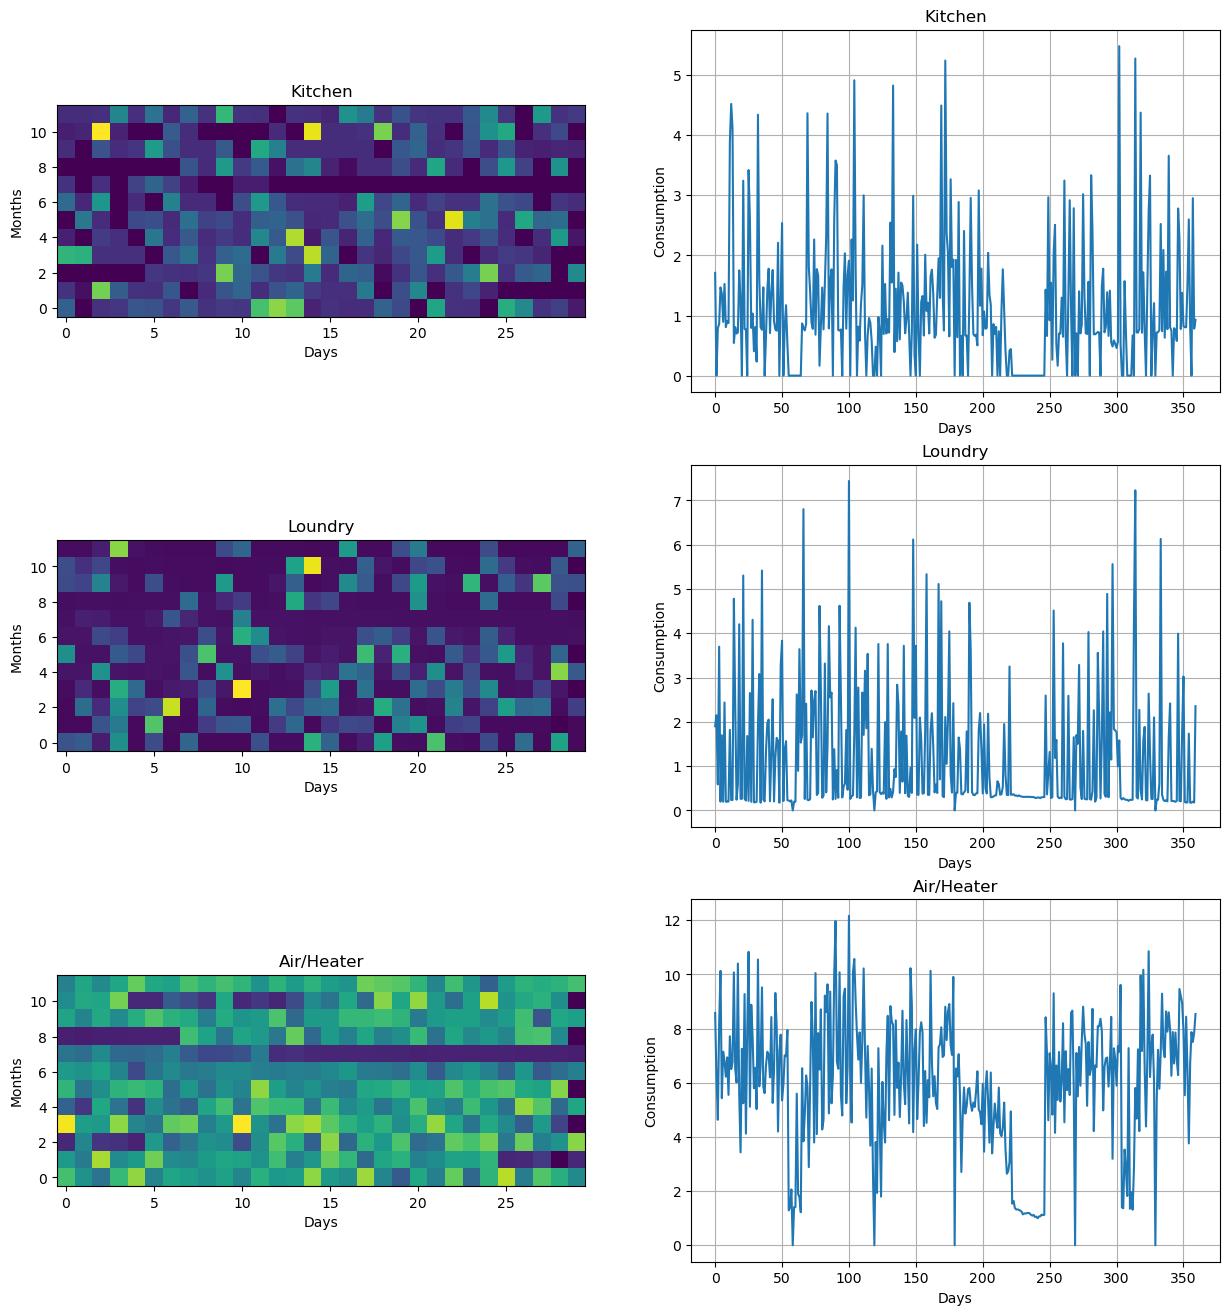

In [38]:
# let's vizualize electricity consumption for all signals in grid (day, month)

kitchen_power = data[:, 0].reshape((12, 360 // 12))
loundry_power = data[:, 1].reshape((12, 360 // 12))
airheater_power = data[:, 2].reshape((12, 360 // 12))
data_to_viz = [kitchen_power, loundry_power, airheater_power]
fig_title = ['Kitchen', 'Loundry', 'Air/Heater']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 16))
for i, ax in enumerate(axes):
    ax[0].set_xlabel('Days')
    ax[0].set_ylabel('Months')
    ax[0].set_title(fig_title[i])
    ax[0].imshow(data_to_viz[i], origin='lower')

    ax[1].set_title(fig_title[i])
    ax[1].plot(data_to_viz[i].flatten())
    ax[1].set_xlabel('Days')
    ax[1].set_ylabel('Consumption')
    ax[1].grid()

### Applying another variant of tSSA

In [54]:
# construct data tensor
data_tensor = data.reshape((12, 30, 3), order='F')

# apply CPD
cpd_rank = 7
factors = tl.decomposition.parafac(data_tensor, cpd_rank, random_state=42)[1]

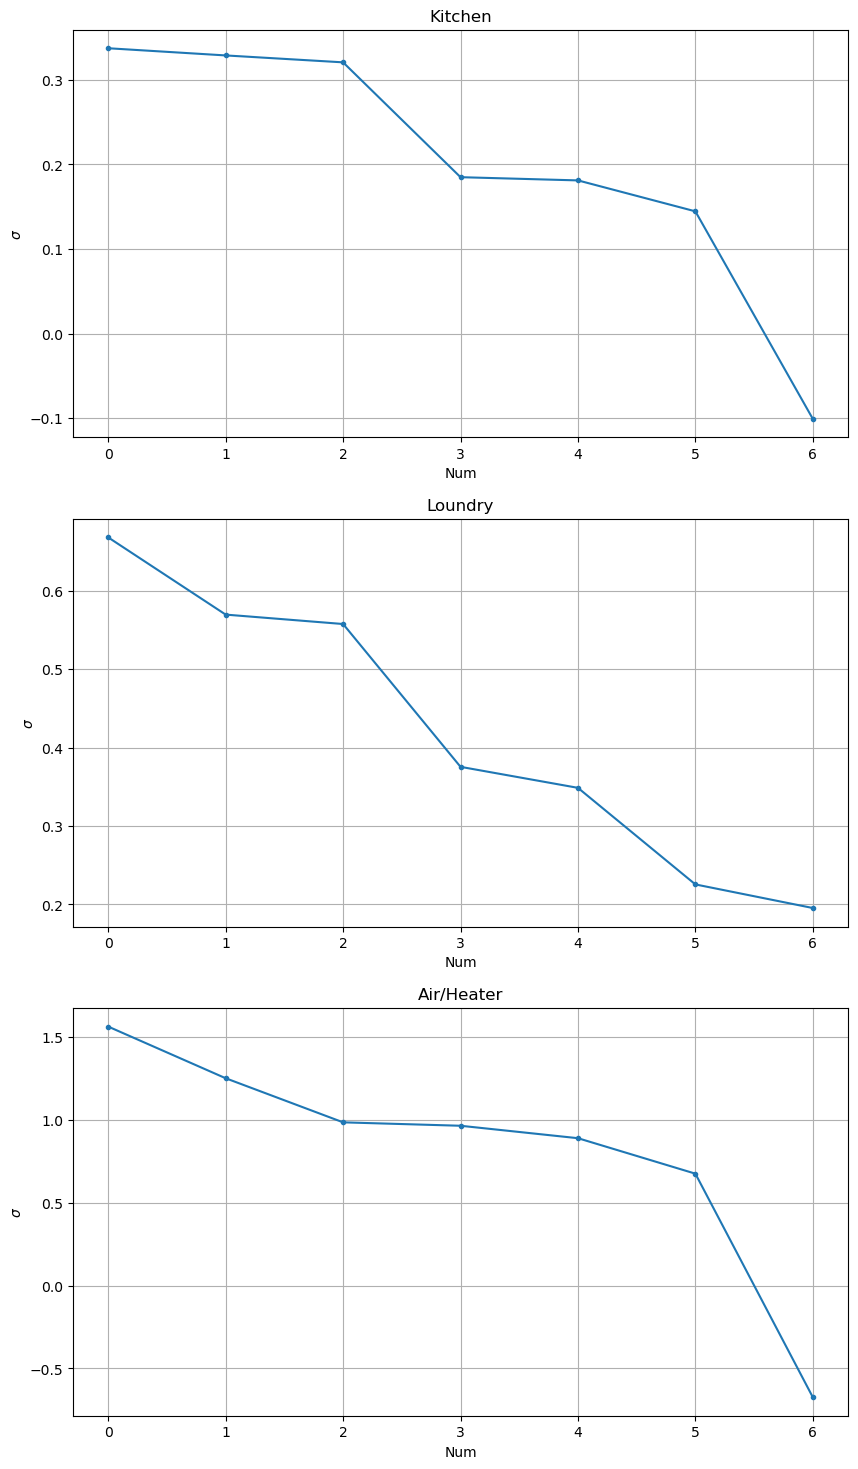

In [56]:
# now let's consider decomposition for all 3 individual signals
# they have common factor matrices but diffrent 'singular' numbers
fig, ax = plt.subplots(nrows=3, figsize=(10, 18))
# array for indecies of intial array in sorted order
ind_sorted = []

for i in range(3):
    # extract singular values
    cur_singular_vals = factors[2][i]
    ind_sorted.append(np.flip(np.argsort(cur_singular_vals)))
    cur_singular_vals = np.flip(np.sort(cur_singular_vals))
    ax[i].plot(cur_singular_vals, marker='.')
    ax[i].set_xlabel('Num')
    ax[i].set_ylabel(r'$\sigma$')
    ax[i].set_title(fig_title[i])
    ax[i].grid()

In [58]:
# based on the proximity of singular values let's group signals. Indecies here are in sorted array of singular values!
group_kitchen = [(0, 1, 2), (3, 4, 5), (6, )]
group_loundry = [(0, ), (1, 2), (3, 4), (5, 6)]
group_airheater = [(0, 1, 2), (3, 4, 5), (6, )]

signals_groups = [group_kitchen, group_loundry, group_airheater]

# container for decomposition of each signal
decomposed_sigs = [[], [], []]

for sig_num, signal_group in enumerate(signals_groups):
    # singular values for individual signal
    cur_singular_vals = factors[2][sig_num]

    for group in signal_group:
        # container for current decomposition
        cur_component = np.zeros(shape=data_tensor.shape[:-1])
        # converted indecies to the ones of intial array of singular values
        true_indecies = ind_sorted[sig_num][list(group)]

        # summing up signals
        for ind in true_indecies:
            cur_component += cur_singular_vals[ind] * np.outer(factors[0][:, ind], factors[1][:, ind])

        # saving component
        decomposed_sigs[sig_num].append(cur_component)        

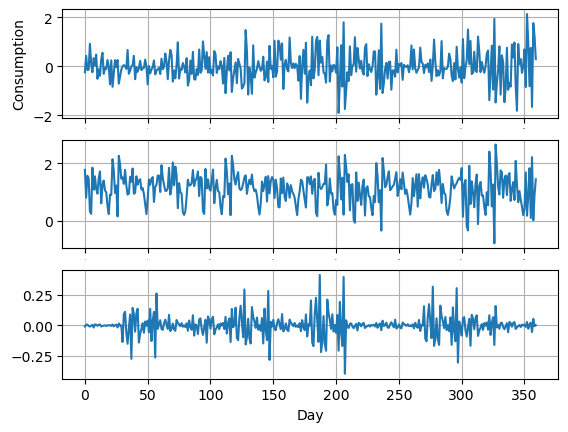

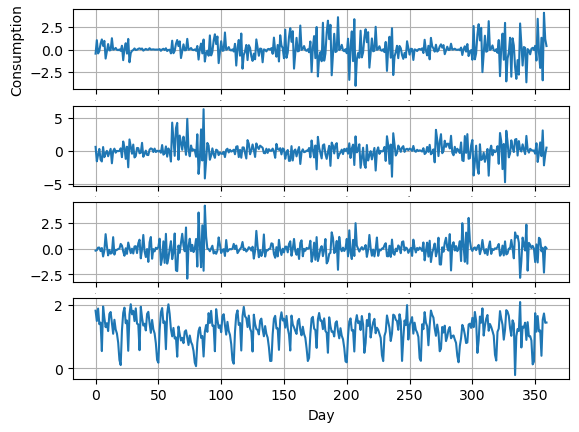

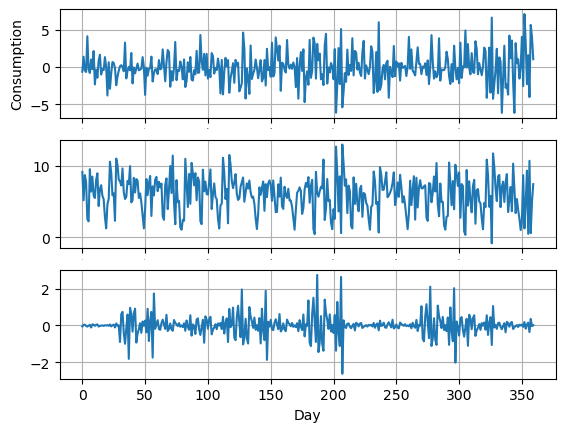

In [69]:
# visualize components for each individual signal
for sig_num in range(3):
    fig, ax = plt.subplots(nrows=len(decomposed_sigs[sig_num]))

    for i, sig_matrix in enumerate(decomposed_sigs[sig_num]):
        ax[i].plot(sig_matrix.flatten())
        if i == 0:
            ax[i].set_ylabel('Consumption')
        if i == len(decomposed_sigs[sig_num]) - 1:
            ax[i].set_xlabel('Day')
        else:
            ax[i].tick_params(axis='x', labelsize=0)
        ax[i].grid()

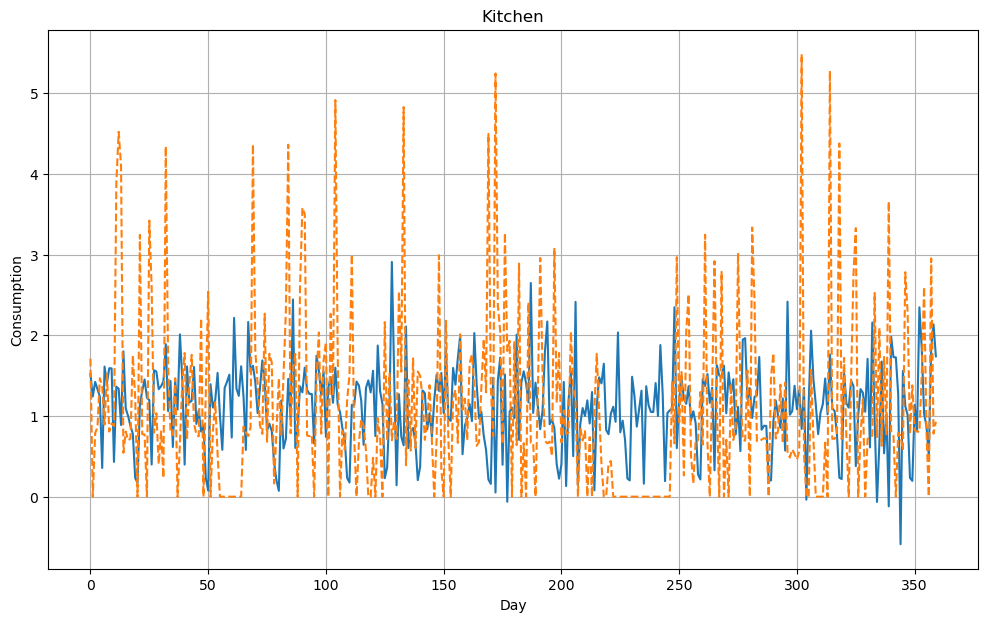

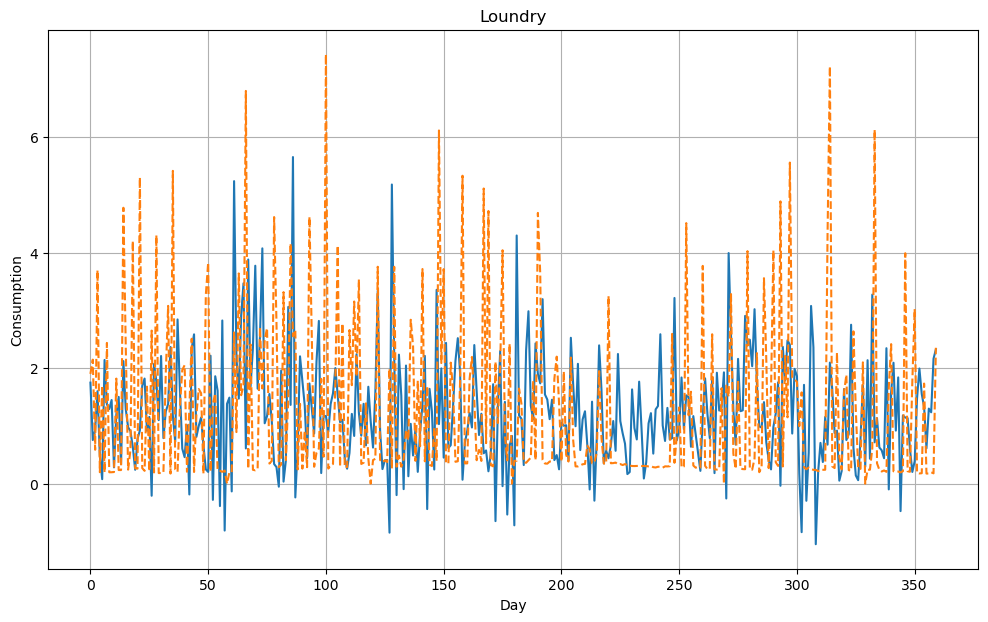

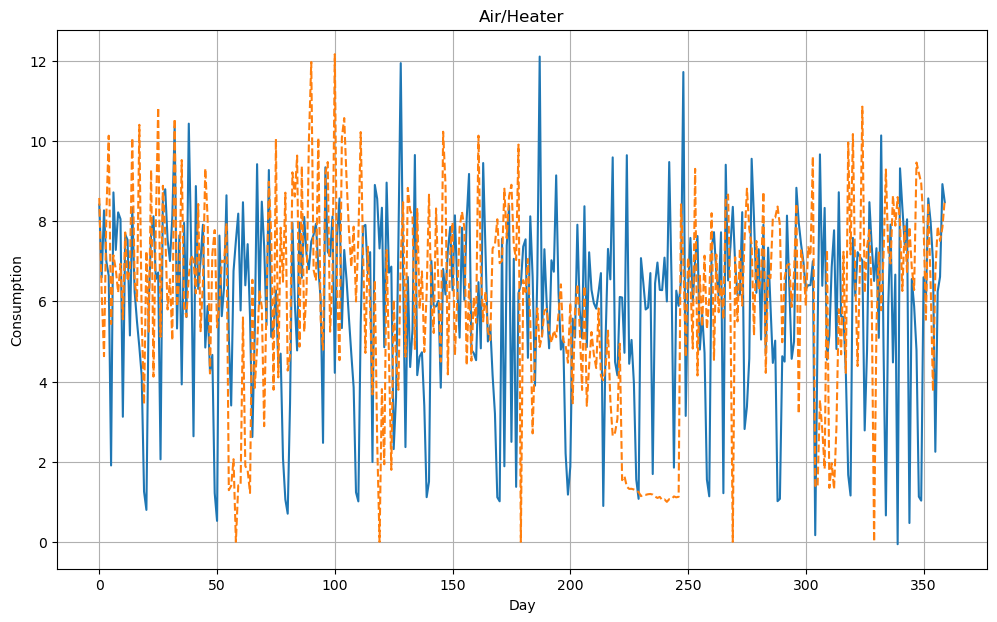

In [64]:
# have a look on the restoration
for sig_num in range(3):
    fig, ax = plt.subplots(figsize=(12, 7))
    restored_signal = sum(decomposed_sigs[sig_num]).flatten()
    ax.plot(restored_signal)
    ax.plot(data_to_viz[sig_num].flatten(), linestyle='--')

    ax.set_ylabel('Consumption')
    ax.set_xlabel('Day')
    ax.set_title(fig_title[sig_num])
    ax.grid()